In [12]:
# Importing everything and checking files in input folder
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from optuna.visualization import plot_optimization_history
from optuna.integration import LightGBMPruningCallback, XGBoostPruningCallback

import shap

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
import miceforest as mf
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import RFECV, mutual_info_classif
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier, DMatrix, plot_importance
from xgboost import cv as xgbcv
from lightgbm import LGBMClassifier, Dataset
from lightgbm import cv as lgbmcv
from sklearn.inspection import permutation_importance

import os
for dirname, _, filenames in os.walk(r'C:\Users\arkma\Sqrt-1\putting the pro in programming\ML\GDSC ML\input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\arkma\Sqrt-1\putting the pro in programming\ML\GDSC ML\input\sample.csv
C:\Users\arkma\Sqrt-1\putting the pro in programming\ML\GDSC ML\input\test (1).csv
C:\Users\arkma\Sqrt-1\putting the pro in programming\ML\GDSC ML\input\train.csv


In [17]:
# Loading the data and target
X_train = pd.read_csv(r'C:\Users\arkma\Sqrt-1\putting the pro in programming\ML\GDSC ML\input\train.csv')
X_train.dropna(subset = 'TARGET', inplace = True) # I can't train the model on rows it does not know the answer for.
# Not going to be imputing on the label :skull:
# X.TARGET.hist() # Both 0 and 1 occur almost 50/50, which is nice. No SMOTE or scale_boost_weight needed.
# No categorical columns also means no need for OneHot or Label Encoding, or using a StackingClassifier with CatBoost or whatever

y_train = X_train['TARGET']                              # Our target.
X_train.drop(columns = ['TARGET', 'ID'], inplace = True) # Plugging data leak.

X_train.head()

,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,n_10,...,n_37,n_38,n_39,n_40,n_41,n_42,circle_1,circle_2,moon_1,moon_2
0,0.356166,-0.220868,NaN,2.740512,NaN,NaN,0.305572,NaN,0.734157,-0.642374,...,1.556758,1.006265,-0.278081,NaN,0.756995,-0.837888,0.087326,-0.598842,1.906352,0.228634
1,-2.074327,2.288908,-0.223467,0.609748,0.365282,NaN,2.733241,NaN,-0.618877,-3.803229,...,-0.040777,-2.696845,NaN,0.102893,-1.882500,0.947588,0.933394,0.219935,0.423200,-0.398878
2,-0.583613,0.585094,NaN,1.203309,NaN,0.176773,0.888503,NaN,0.068474,-0.723592,...,0.519745,1.170156,NaN,NaN,-0.741554,-1.876837,-0.792849,-0.607845,-0.785075,0.328256
3,0.061271,NaN,-3.005657,0.164192,1.823587,0.929056,1.104890,NaN,-0.513047,1.473058,...,0.011771,-1.481368,1.796582,0.346481,0.177611,1.478584,0.005646,-0.825592,-1.038314,0.180055
5,-2.704906,-2.716453,-1.194904,-0.151409,0.143884,-0.848596,-1.361852,NaN,NaN,NaN,...,NaN,-2.476042,NaN,1.328722,-0.552372,2.286373,0.284369,0.462163,1.884952,0.457409


In [4]:
# Mean Imputation
temp = X_train.columns
imputer = SimpleImputer(strategy = 'mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train))
X_train.columns = temp

In [18]:
# KNN Imputation
temp = X_train.columns
imputer = KNNImputer()
X_train = pd.DataFrame(imputer.fit_transform(X_train))
X_train.columns = temp

In [9]:
# Iterative Imputation
temp = X_train.columns
imputer = IterativeImputer()
X_train = pd.DataFrame(imputer.fit_transform(X_train))
X_train.columns = temp

In [19]:
X_train.head()

,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,n_10,...,n_37,n_38,n_39,n_40,n_41,n_42,circle_1,circle_2,moon_1,moon_2
0,0.356166,-0.220868,-0.187555,2.740512,0.227007,-0.248154,0.305572,-0.282426,0.734157,-0.642374,...,1.556758,1.006265,-0.278081,-0.366379,0.756995,-0.837888,0.087326,-0.598842,1.906352,0.228634
1,-2.074327,2.288908,-0.223467,0.609748,0.365282,-0.027466,2.733241,-1.120224,-0.618877,-3.803229,...,-0.040777,-2.696845,0.267538,0.102893,-1.882500,0.947588,0.933394,0.219935,0.423200,-0.398878
2,-0.583613,0.585094,-0.742903,1.203309,-0.524700,0.176773,0.888503,-1.468633,0.068474,-0.723592,...,0.519745,1.170156,-1.145339,1.156469,-0.741554,-1.876837,-0.792849,-0.607845,-0.785075,0.328256
3,0.061271,1.100168,-3.005657,0.164192,1.823587,0.929056,1.104890,-0.367908,-0.513047,1.473058,...,0.011771,-1.481368,1.796582,0.346481,0.177611,1.478584,0.005646,-0.825592,-1.038314,0.180055
4,-2.704906,-2.716453,-1.194904,-0.151409,0.143884,-0.848596,-1.361852,0.051743,-0.387713,0.812654,...,0.255085,-2.476042,-0.191664,1.328722,-0.552372,2.286373,0.284369,0.462163,1.884952,0.457409


In [20]:
gnb = GaussianNB()
gnb_cv_scores = cross_val_score(gnb, X_train, y_train, cv=5, scoring='accuracy')
print(gnb_cv_scores)
print(gnb_cv_scores.mean())

[0.91114575 0.91738114 0.91114575 0.9024961  0.91653666]
0.9117410807110382


In [21]:
xgb = XGBClassifier(random_state = 42)
xgb_cv_scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='accuracy')
print(xgb_cv_scores)
print(xgb_cv_scores.mean())

[0.90724864 0.90802806 0.90802806 0.90093604 0.91185647]
0.9072194532364304


In [ ]:
# imputation strats:
# mean:
# gnb: 0.9126771181525358, xgb: 0.9087787860696033
# iterative:
# gnb: 0.9129888874432609, xgb: 0.908466651994217
# knn:
# gnb: 0.9117410807110382, xgb: 0.9072194532364304

# Conclusion: I have no idea. I only did this test at the unfortunate timing of the final day of the contest,
# and the only way to truly test it would be to submit every output of my model thrice.

In [31]:
# Information and warnings

# X_train shape = (6413, 46)

# ⚠️ Don't use regression for classification things.
# XGBRegressor → XGBClassifier
# mutual_info_regression → mutual_info_classif

# ⚠️ Any data transformations you do on the train dataset, you must do on the test dataset.

# ⚠️ Aggressive hyperparameter search can cause overfitting *despite* cross validation!
# It may tune itself too much to the cv process and the tuning may fail to generalise outside of that process.
# More rounds of hyperparameter tuning isn't healthy.
# Also, if you want a reality check on how well the tuning would perform on the test dataset; use nested cross validation.

# The fact that a Gaussian Naive Bayes model or a LogisticRegressor
# gives better accuracy than an untuned XGBClassifier,
# and the fact that there is zero correlation between any of the variables given per the heatmap,
# points to the fact that there is little or no interdependence between variables.
# ...or maybe there is, but my methods are too underpowered or my intellect too stupid to detect it.
# In either case I have no choice but to assume no interdependence.
# ⇒ Naive models work
# ⇒ There should be little need for imputing based on how other variables are.

##### Trying different models

In [32]:
lr = LogisticRegression(random_state = 42)
lr_cv_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy')
print(lr_cv_scores)
print(lr_cv_scores.mean())

[0.9127046  0.91582229 0.90958691 0.89859594 0.91185647]
0.9097132427775676


In [33]:
rf = RandomForestClassifier(random_state = 42)
rf_cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print(rf_cv_scores)
print(rf_cv_scores.mean())

[0.91504287 0.91816056 0.91582229 0.91341654 0.91809672]
0.9161077962993811


In [34]:
RF_PARAMS = {'max_depth': 100, 'bootstrap': False, 'n_estimators': 972, 'min_samples_split': 17, 'min_samples_leaf': 45, 'max_features': 'sqrt', 'class_weight': None, 'criterion': 'gini', 'min_weight_fraction_leaf': 0.38769271847893305, 'max_leaf_nodes': 43, 'min_impurity_decrease': 0.14872963465632788, 'ccp_alpha': 0.2723672552868967,'random_state': 42}
rf_mod = RandomForestClassifier(**RF_PARAMS)
rf_mod_cv_scores = cross_val_score(rf_mod, X_train, y_train, cv=5, scoring='accuracy')
print(rf_mod_cv_scores)
print(rf_mod_cv_scores.mean())
# ...thanks for absolutely nothing, optuna

[0.91504287 0.91893998 0.91504287 0.91263651 0.91653666]
0.9156397775786325


In [35]:
xgb = XGBClassifier(random_state = 42)
xgb_cv_scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='accuracy')
print(xgb_cv_scores)
print(xgb_cv_scores.mean())

[0.91114575 0.90880748 0.90802806 0.90483619 0.91107644]
0.9087787860696033


In [68]:
XGBLINEAR_PARAMS = {'booster': 'gblinear', 'n_estimators': 998, 'alpha': 0.008827781309833412, 'lambda': 8.425697913178144e-07, 'updater': 'shotgun', 'feature_selector': 'cyclic'}
xgb_linear = XGBClassifier(**XGBLINEAR_PARAMS)
xgb_linear_cv_scores = cross_val_score(xgb_linear, X_train, y_train, cv=5, scoring='accuracy')
print(xgb_linear_cv_scores)
print(xgb_linear_cv_scores.mean())

[0.91582229 0.91738114 0.91426345 0.90717629 0.91809672]
0.9145479770866594


In [37]:
lgbm = LGBMClassifier(verbosity = -1, random_state = 42)
lgbm_cv_scores = cross_val_score(lgbm, X_train, y_train, cv=5, scoring='accuracy')
print(lgbm_cv_scores)
print(lgbm_cv_scores.mean())

[0.90880748 0.91348402 0.90802806 0.89703588 0.9149766 ]
0.9084664088044425


In [69]:
gnb = GaussianNB()
gnb_cv_scores = cross_val_score(gnb, X_train, y_train, cv=5, scoring='accuracy')
print(gnb_cv_scores)
print(gnb_cv_scores.mean())
# holy shit that was *fast*, especially for its accuracy.

[0.91114575 0.91816056 0.91036633 0.90639626 0.91731669]
0.9126771181525358


In [41]:
voting = VotingClassifier(estimators=[('lr', lr), ('rf', rf), ('xgb_linear', xgb_linear), ('lgbm', lgbm), ('gnb', gnb)])
voting_scores = cross_val_score(voting, X_train, y_train, cv=5, scoring='accuracy')
print(voting_scores)
print(voting_scores.mean())

[0.91582229 0.91816056 0.91192518 0.90717629 0.91731669]
0.9140802015556849


In [42]:
voting = VotingClassifier(estimators=[('lr', lr), ('rf', rf), ('xgb', xgb), ('xgb_linear', xgb_linear), ('lgbm', lgbm), ('gnb', gnb)])
voting_scores = cross_val_score(voting, X_train, y_train, cv=5, scoring='accuracy')
print(voting_scores)
print(voting_scores.mean())

[0.91504287 0.91582229 0.9127046  0.90639626 0.91653666]
0.9133005351390985


In [45]:
stacking = StackingClassifier(estimators=[('lr', lr), ('rf', rf), ('xgb_linear', xgb_linear), ('lgbm', lgbm), ('gnb', gnb)])
stacking_scores = cross_val_score(stacking, X_train, y_train, cv=5, scoring='accuracy')
print(stacking_scores)
print(stacking_scores.mean())

[0.9127046  0.91660171 0.91192518 0.90717629 0.91731669]
0.9131448936835103


In [46]:
stacking = StackingClassifier(estimators=[('lr', lr), ('rf', rf), ('xgb', xgb), ('xgb_linear', xgb_linear), ('lgbm', lgbm), ('gnb', gnb)])
stacking_scores = cross_val_score(stacking, X_train, y_train, cv=5, scoring='accuracy')
print(stacking_scores)
print(stacking_scores.mean())

[0.91426345 0.91660171 0.9127046  0.90405616 0.91653666]
0.9128325164183495


In [79]:
# Seems like bad models just make the ensemble worse. The Corps is only as strong as its weakest link...
voting = VotingClassifier(estimators=[('rf', rf), ('xgb_linear', xgb_linear), ('gnb', gnb)])
voting_scores = cross_val_score(voting, X_train, y_train, cv=5, scoring='accuracy')
print(voting_scores)
print(voting_scores.mean())

[0.9127046  0.91816056 0.91348402 0.90873635 0.91887676]
0.9143924572259585


In [49]:
model = KNeighborsClassifier()
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(scores)
print(scores.mean())

[0.76071707 0.77630553 0.75136399 0.77301092 0.74882995]
0.7620454935110889


In [76]:
svc = SVC()
scores = cross_val_score(svc, X_train, y_train, cv=5, scoring='accuracy')
print(scores)
print(scores.mean())

[0.90880748 0.90880748 0.90802806 0.91107644 0.91263651]
0.9098711945360123


In [77]:
lsvc = LinearSVC()
scores = cross_val_score(lsvc, X_train, y_train, cv=5, scoring='accuracy')
print(scores)
print(scores.mean())
# didnt add this to votingclassifier because adding this reduced accuracy by 0.002 for some reason

[0.91348402 0.91582229 0.91036633 0.90405616 0.91107644]
0.9109610495097902


#### Feature Transformation/Engineering

In [3]:
# Creating the radius column
X_train['radius'] = X_train['circle_1'] ** 2 + X_train['circle_2'] ** 2

-1 values = 28
eps=0.1, min_samples=13


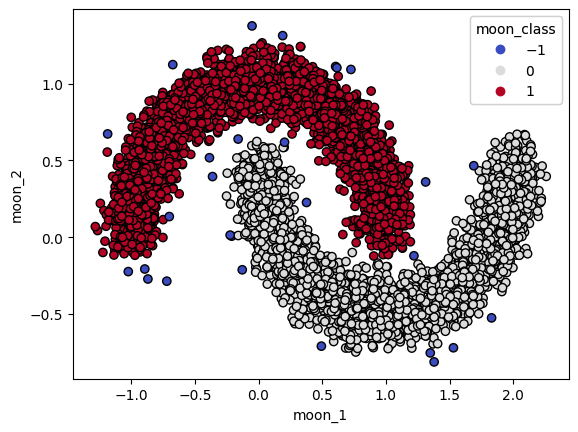

In [13]:
# Creating the 'moon_class' column using DBSCAN
# vs HDBSCAN, Spectral Clustering, OPTICS
# https://scikit-learn.org/1.5/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

def scatterplot(df, class_col, x_col, y_col):
    # yes I know I used france's flag's colors stop
    scatter = plt.scatter(df[x_col], df[y_col], c=df[class_col], cmap="coolwarm", edgecolors="k")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    legend = plt.legend(*scatter.legend_elements(), title=class_col)
    plt.gca().add_artist(legend)
    plt.show()

eps, min_samples = 0.1, 13 # These parameters lead to the least number of -1 values
dbscan = DBSCAN(eps=0.1, min_samples=13)
X_train['moon_class'] = dbscan.fit_predict(X_train[['moon_1', 'moon_2']])
print(f'-1 values = {X_train[X_train['moon_class'] == -1].shape[0]}')
print(f'{eps=}, {min_samples=}')
scatterplot(X_train, 'moon_class', 'moon_1', 'moon_2')

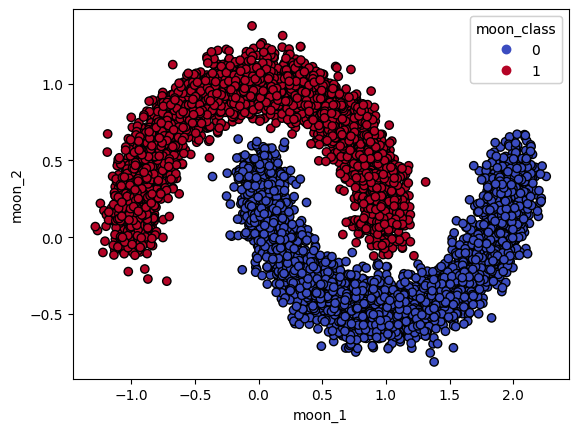

In [14]:
# DBSCAN is smart... but not smart enough. Using KNN to fill the '-1' potholes.
# Now that we have a rough idea of what moon_class should be using DBSCAN
# we can use much superior supurvised learning to figure out what should be the fate of the -1's

train_data = X_train[X_train['moon_class'] != -1]
test_data = X_train[X_train['moon_class'] == -1]

X_train1 = train_data[['moon_1', 'moon_2']]
y_train1 = train_data['moon_class']
X_test1 = test_data[['moon_1', 'moon_2']]

knn = KNeighborsClassifier(n_neighbors=5, weights='distance') # having distance as weights just makes more sense tbh
knn.fit(X_train1, y_train1)
predicted_labels = knn.predict(X_test1)
X_train.loc[X_train['moon_class'] == -1, 'moon_class'] = predicted_labels

scatterplot(X_train, 'moon_class', 'moon_1', 'moon_2')
# Surprisingly... it looks perfect. Even for the controversial datapoints it looks great.

In [15]:
# Plotting feature importance using permutation_importance
X_traind = X_train.drop(columns = ['n_42']) # this feature is so important it literally hides all the other features on the graph
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_traind, y_train, stratify=y_train, random_state=42)

model = XGBClassifier(seed = 42)
model.fit(X_train1, y_train1)
print(f"RF test accuracy: {model.score(X_test1, y_test1):.3f}")
result = permutation_importance(
    model, X_test1, y_test1, n_repeats=10, random_state=42,
)

plt.figure(figsize=(200, 20))
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train1.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.set_size_inches(16, 10)  # Adjust these values as needed
ax.figure.tight_layout()

RF test accuracy: 0.504


KeyboardInterrupt: 

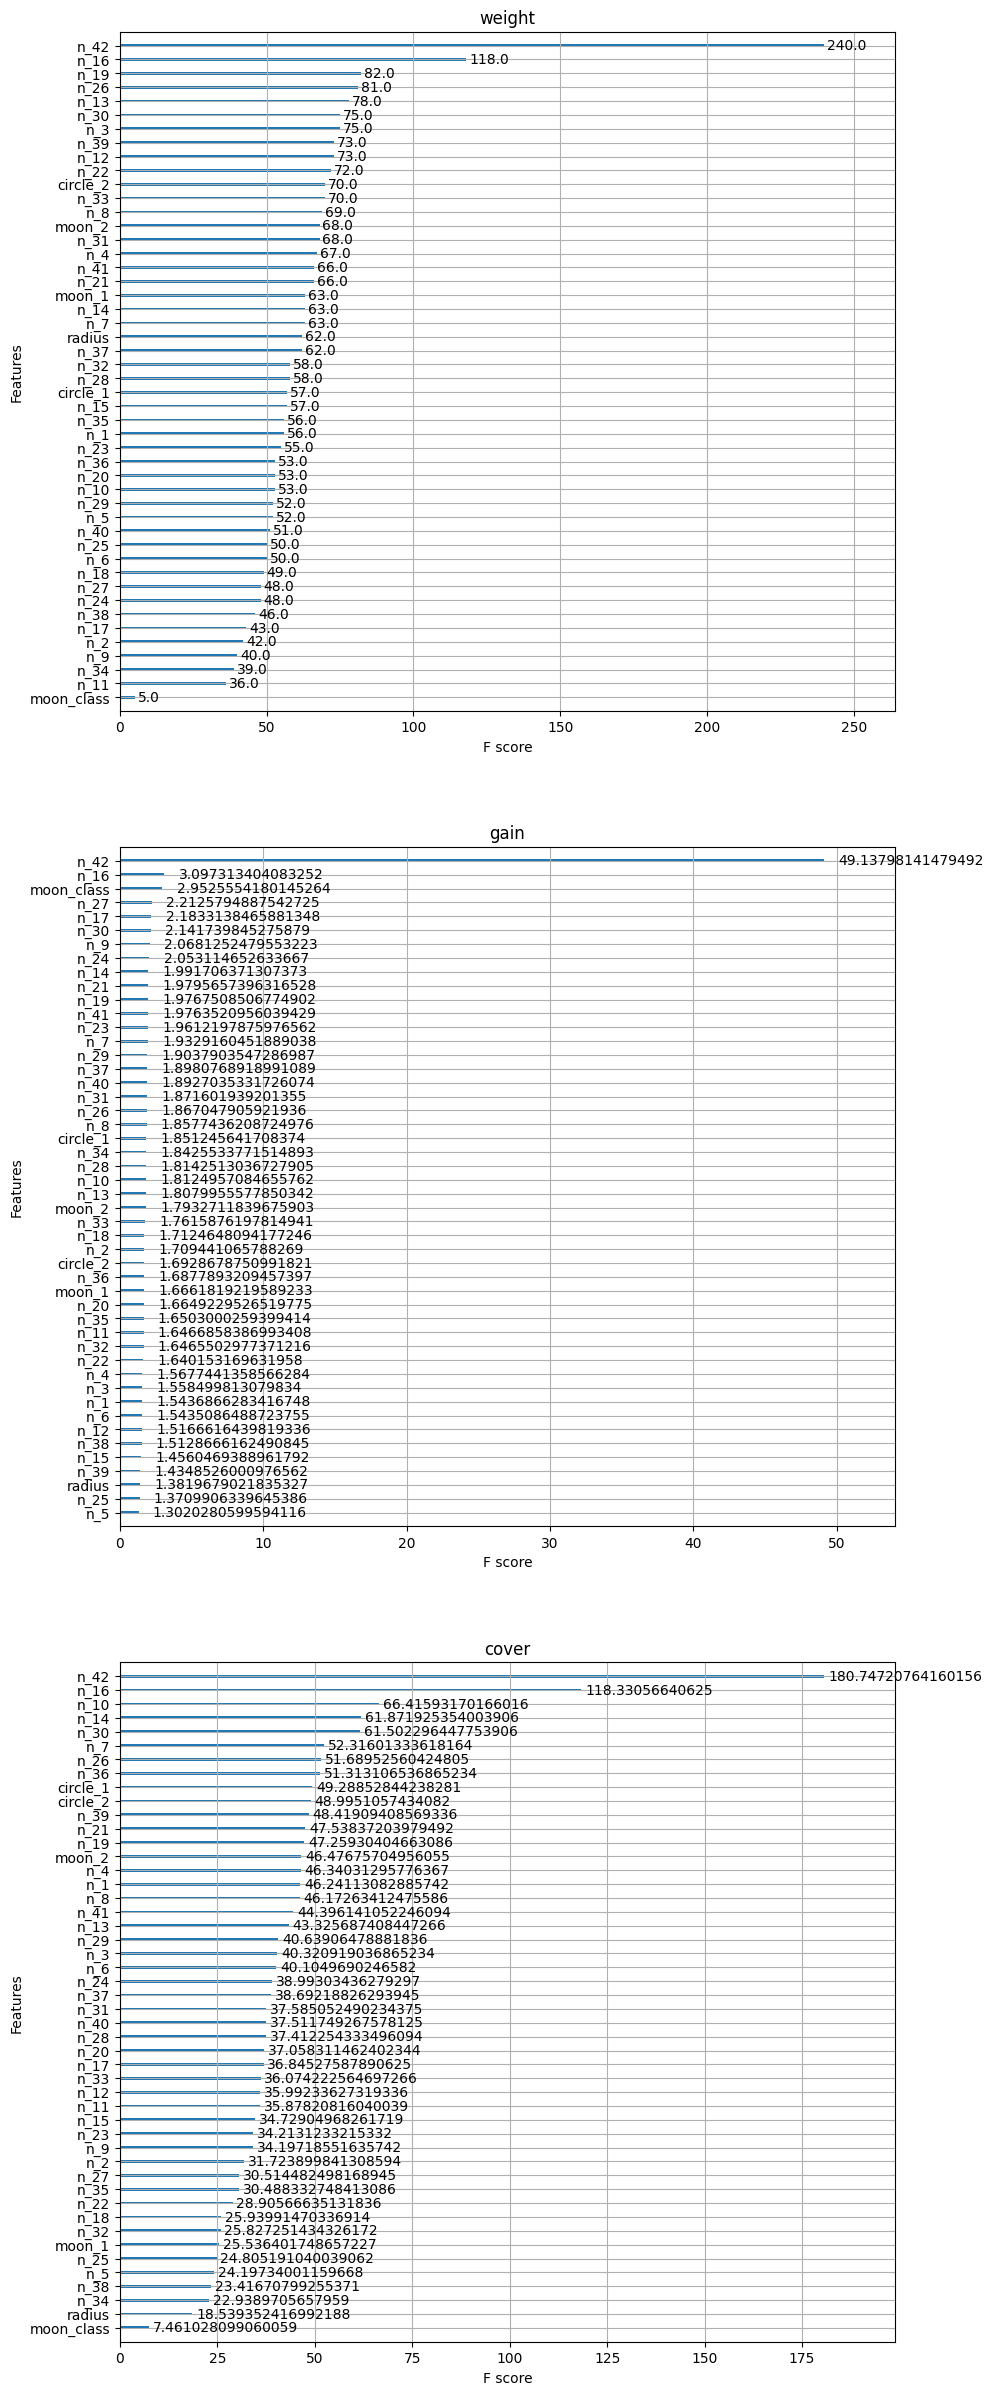

'\nif you have 100 observations, 4 features and 3 trees,\nand suppose feature1 is used to decide the leaf node for 10, 5, and 2 observations in tree1, tree2 and tree3 respectively;\nthen the metric will count cover for this feature as 10+5+2 = 17 observations.\nThis will be calculated for all the 4 features and the cover will be 17 expressed as a percentage for all features cover metrics.\n'

In [58]:
# Plotting feature importance using xgboost
# have to do this otherwise you can't see the correct column names and instead see 'f_41' instead of 'n_42'
X_train1 = pd.DataFrame(X_train, columns=X_train.columns, index=X_train.index)
model = XGBClassifier() # once you get addicted to the speed of xgboost there is no coming back
# lgbm may be twice as fast but it's 0.03% less accurate.
model.fit(X_train1, y_train)

fig, axs = plt.subplots(3, 1, figsize=(10, 30))
for ax, importance_type in zip(axs, ['weight', 'gain', 'cover']):
    plot_importance(model, ax=ax, importance_type = importance_type, title = importance_type) # this function is sick
plt.show()
# weight: number of times a feature appears in a tree.
# gain: average gain of splits which use the feature.
"calculated by taking each feature's contribution for each tree in the model"
# cover: average coverage of splits which use the feature; coverage: number of samples affected by the split.
"""
if you have 100 observations, 4 features and 3 trees,
and suppose feature1 is used to decide the leaf node for 10, 5, and 2 observations in tree1, tree2 and tree3 respectively;
then the metric will count cover for this feature as 10+5+2 = 17 observations.
This will be calculated for all the 4 features and the cover will be 17 expressed as a percentage for all features cover metrics.
"""

# Conclusions: ...I don't know. some observations:
# 1.   moon_class being low in weight makes sense. It's binary; it can only be used once in each tree.
# 2.   ...but what I am concerned about is this: why does moon_class have so little cover?
#      Is it because it's used earlier in the tree instead of being one of the final leaves?
# 3.   Why does moon_2 rank so much higher than moon_1? I earlier assumed this to be evidence that XGB doesn't know wtf it's doing,
#      but the *sheer difference* in cover they have, not to mention the difference in cover of moon_class and moon_2...
#      Same for circle_2 and circle_1.
#      They are supposed to be representing a shape in a 2D plot.
#      I assumed the true values were dependent on the shape and not the coordinates themselves, because that made intuitive sense
#      ...but was I wrong? I mean I was obviously wrong, but why was I wrong?
# 4.   Plotting the same after removing moon_i and circle_i doesn't do much, I am afraid.

In [ ]:
# Plotting SHAP values

In [ ]:
# Checking the code in the fucking around section, it seems the accuracy is best when I... not remove any columns at all.
# So I won't. Even though I have heard having redundant columns is a bad thing apparently... 
# but it increases my accuracy so should it matter?

##### Data Experimentation

In [18]:
# Histogram
"""
X_train.hist(bins=30, figsize=(15, 10))
"""
# circles and moons are clearly weird... non-Gaussian distributions.

'\nX_train.hist(bins=30, figsize=(15, 10))\n'

In [19]:
# Plotting circles and moons
"""
sns.pairplot(X_train[['circle_1', 'circle_2']])
sns.pairplot(X_train[['moon_1', 'moon_2']])
plt.show()
"""

# The graphs look cool but I have no idea what to do with this information.

"\nsns.pairplot(X_train[['circle_1', 'circle_2']])\nsns.pairplot(X_train[['moon_1', 'moon_2']])\nplt.show()\n"

In [20]:
# Correlations

# Conclusion: n_42 is pretty important... no idea what do with this this information. 

In [4]:
# Checking what good StandardScaler does me
model1 = make_pipeline(SimpleImputer(strategy = 'mean'),
                       StandardScaler(),
                       XGBClassifier(seed = 42))
model2 = make_pipeline(SimpleImputer(strategy = 'mean'),
                       RobustScaler(),
                       XGBClassifier(seed = 42))
model3 = make_pipeline(SimpleImputer(strategy = 'mean'),
                       MinMaxScaler(feature_range = (-1, 1)),
                       XGBClassifier(seed = 42))
model0 = make_pipeline(SimpleImputer(strategy = 'mean'),
                       XGBClassifier(seed = 42))

for model in [model0, model1, model2, model3]:
    cv_scores = cross_val_score(model, X_train, y_train,
                                    cv = 5,
                                    scoring = 'accuracy')
    print(cv_scores)
    print(cv_scores.mean())

"""
[0.91114575 0.90880748 0.90802806 0.90483619 0.91107644]
0.9087787860696033
[0.91114575 0.90880748 0.90802806 0.90483619 0.91107644]
0.9087787860696033
[0.90880748 0.90880748 0.90802806 0.90483619 0.91107644]
0.908311132133516
[0.90880748 0.90880748 0.90802806 0.90483619 0.91107644]
0.908311132133516
"""

# Conclusion: ...in retrospect it makes sense that the data was already StandardScaled. 
# Zero difference in non-StandardScaled and StandardScaled models no matter what I change in the model parameters.
# RobustScale and MinMaxScale probably don't work because I don't think I have any outliers in my data.
# "If your data is already pretty close to normally distributed then you could to lose more fidelity with RobustScaler 
# because it's only looking at the interquartile range."

[0.91114575 0.90880748 0.90802806 0.90483619 0.91107644]
0.9087787860696033
[0.91114575 0.90880748 0.90802806 0.90483619 0.91107644]
0.9087787860696033
[0.90880748 0.90880748 0.90802806 0.90483619 0.91107644]
0.908311132133516
[0.90880748 0.90880748 0.90802806 0.90483619 0.91107644]
0.908311132133516


'\n[0.90491037 0.90491037 0.8994544  0.89157566 0.90405616]\n0.9009813923344151\n[0.90491037 0.90491037 0.8994544  0.89157566 0.90405616]\n0.9009813923344151\n'

In [30]:
# Check Mutual Information Classif
# ⚠️ see warning at the end below
"""
# mutual_info_classif, not regression!!!
mi_scores = mutual_info_classif(X_train, y_train)
mi_scores = pd.Series(mi_scores, index = X_train.columns)
mi_scores.sort_values(ascending = False, inplace = True)

print(mi_scores)
"""

"""
n_42          0.456437
n_21          0.011849
n_19          0.011663
n_26          0.010454
n_35          0.009980
n_30          0.007294
n_38          0.006288
n_14          0.006269
moon_class    0.005149
n_25          0.004983
n_31          0.004514
n_20          0.004343
n_40          0.003771
n_33          0.003194
n_1           0.002949
n_24          0.002863
n_29          0.002392
moon_2        0.001982
n_7           0.001214
n_13          0.000824
n_39          0.000278
moon_1        0.000045
n_11          0.000000
n_12          0.000000
n_2           0.000000
n_3           0.000000
n_5           0.000000
n_4           0.000000
n_10          0.000000
n_9           0.000000
n_6           0.000000
n_8           0.000000
n_16          0.000000
n_15          0.000000
n_27          0.000000
n_28          0.000000
n_17          0.000000
n_18          0.000000
n_22          0.000000
n_23          0.000000
n_32          0.000000
n_37          0.000000
n_34          0.000000
n_36          0.000000
circle_2      0.000000
circle_1      0.000000
n_41          0.000000
radius        0.000000
"""

# Conclusion: ...I don't know. Some observations...
# 1. How can circle_1 and circle_2 have higher MI than radius even though radius improved accuracy when I last tested it?
# 1.1. I have heard that columns with complex relations or formulas are worse for MLs... but what about the test I had done earlier?
# 2. Figuring out a way to make the moon columns manageable should be a high priority.

### NEW CONCLUSION:
# MI is *extremely* volatile; sometimes moon_class ranks very highly, sometimes it ranks lower than moon_2 (??),
# and sometimes it's at *the bottom of the list* (????)
# For high dimensional models it's very hard for MI to work because apparently it works on KNN.
# Instead, use feature selection features inbuilt into XGB or RFE, which tends to be more stable.
# (seriously the kaggle tutorial I learnt this from should have warned me about this...)
# ((or am I doing something wrong?))

n_42          0.456437
n_21          0.017084
n_26          0.012135
n_33          0.011696
n_30          0.010740
n_19          0.010636
n_38          0.010196
moon_class    0.007434
n_24          0.007061
n_1           0.006941
n_25          0.006221
n_20          0.003276
n_31          0.002862
n_14          0.002423
n_35          0.002213
moon_2        0.001982
n_29          0.000888
n_3           0.000813
n_13          0.000638
n_10          0.000146
moon_1        0.000045
n_16          0.000000
n_11          0.000000
n_15          0.000000
n_4           0.000000
n_2           0.000000
n_5           0.000000
n_12          0.000000
n_9           0.000000
n_6           0.000000
n_7           0.000000
n_8           0.000000
n_32          0.000000
n_28          0.000000
n_27          0.000000
n_23          0.000000
n_17          0.000000
n_18          0.000000
n_22          0.000000
n_34          0.000000
n_40          0.000000
n_39          0.000000
n_37          0.000000
n_36       

'\nn_42          0.456437\nn_21          0.011849\nn_19          0.011663\nn_26          0.010454\nn_35          0.009980\nn_30          0.007294\nn_38          0.006288\nn_14          0.006269\nmoon_class    0.005149\nn_25          0.004983\nn_31          0.004514\nn_20          0.004343\nn_40          0.003771\nn_33          0.003194\nn_1           0.002949\nn_24          0.002863\nn_29          0.002392\nmoon_2        0.001982\nn_7           0.001214\nn_13          0.000824\nn_39          0.000278\nmoon_1        0.000045\nn_11          0.000000\nn_12          0.000000\nn_2           0.000000\nn_3           0.000000\nn_5           0.000000\nn_4           0.000000\nn_10          0.000000\nn_9           0.000000\nn_6           0.000000\nn_8           0.000000\nn_16          0.000000\nn_15          0.000000\nn_27          0.000000\nn_28          0.000000\nn_17          0.000000\nn_18          0.000000\nn_22          0.000000\nn_23          0.000000\nn_32          0.000000\nn_37         

In [46]:
# Checking how good the model performs without the radius column, with the radius and circle columns, and with only the radius columns without the circle columms

def test(excluded_columns=None):
    global y_train, X_train
    PARAMS = {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'random_state': 42}


    model = XGBClassifier(**PARAMS)

    if excluded_columns:
        X_train_dropped = X_train.drop(columns=excluded_columns)
    else:
        X_train_dropped = X_train
    scores = cross_val_score(model, X_train_dropped, y_train, cv=4, scoring='accuracy')
    print(f'{excluded_columns=}')
    print(PARAMS)
    print(scores)
    print(scores.mean())
    classification_report(y_train, )
    
    
test(['circle_1', 'circle_2']) # Radius only
test(['radius']) # Circle columns only
test() # Both
test(['circle_1', 'circle_2', 'radius']) # None; should perform the worst
"""
excluded_columns = ['circle_1', 'circle_2']
learning_rate = 0.05
 Score = 0.9120947630922693

excluded_columns = ['radius']
learning_rate = 0.05
 Score = 0.9152119700748129

excluded_columns = None
learning_rate = 0.05
 Score = 0.9102244389027432

excluded_columns = ['circle_1', 'circle_2', 'radius']
learning_rate = 0.05
 Score = 0.9089775561097256
"""

# Conclusion: using just the radius does indeed bring out more performance (especially at higher n_estimators and max_depth, and lower learning_rate's)

# NEW RESULTS:
"""
excluded_columns = ['circle_1', 'circle_2']
learning_rate = 0.05
Average CV Score = 0.9077
Standard Deviation of Scores = 0.0061

excluded_columns = ['radius']
learning_rate = 0.05
Average CV Score = 0.9085
Standard Deviation of Scores = 0.0039

excluded_columns = None
learning_rate = 0.05
Average CV Score = 0.9116
Standard Deviation of Scores = 0.0062

excluded_columns = ['circle_1', 'circle_2', 'radius']
learning_rate = 0.05
Average CV Score = 0.9099
Standard Deviation of Scores = 0.0042
"""
# NEW CONCLUSION: what the fuck.
# well when I only have radius there's more variance in standard deviation so...

excluded_columns = ['circle_1', 'circle_2']
learning_rate = 0.05
Average CV Score = 0.9077
Standard Deviation of Scores = 0.0061

excluded_columns = ['radius']
learning_rate = 0.05
Average CV Score = 0.9085
Standard Deviation of Scores = 0.0039

excluded_columns = None
learning_rate = 0.05
Average CV Score = 0.9116
Standard Deviation of Scores = 0.0062

excluded_columns = ['circle_1', 'circle_2', 'radius']
learning_rate = 0.05
Average CV Score = 0.9099
Standard Deviation of Scores = 0.0042



"\nexcluded_columns = ['circle_1', 'circle_2']\nlearning_rate = 0.05\n Score = 0.9120947630922693\n\nexcluded_columns = ['radius']\nlearning_rate = 0.05\n Score = 0.9152119700748129\n\nexcluded_columns = None\nlearning_rate = 0.05\n Score = 0.9102244389027432\n\nexcluded_columns = ['circle_1', 'circle_2', 'radius']\nlearning_rate = 0.05\n Score = 0.9089775561097256\n"

In [47]:
# Same as above but for moon
test(['moon_1', 'moon_2']) # moon_class only
test(['moon_class']) # moon_i columns only
test() # Both
test(['moon_1', 'moon_2', 'moon_class']) # None; should perform the worst

"""
excluded_columns = ['moon_1', 'moon_2']
learning_rate = 0.05
 Score = 0.9164588528678305

excluded_columns = ['moon_class']
learning_rate = 0.05
 Score = 0.9164588528678305

excluded_columns = None
learning_rate = 0.05
 Score = 0.912718204488778

excluded_columns = ['moon_1', 'moon_2', 'moon_class']
learning_rate = 0.05
 Score = 0.9120947630922693
"""

# Conclusion: seems like the xgb regressor handled the moon labels just fine.
# ...still. I think I will keep the moon_class only.
# Keeping all three seems to negatively affect the model for some reason. I guess it makes sense; curse of dimensionality and all

# NEW DATA:
"""
excluded_columns = ['moon_1', 'moon_2']
learning_rate = 0.05
Average CV Score = 0.9089
Standard Deviation of Scores = 0.0030

excluded_columns = ['moon_class']
learning_rate = 0.05
Average CV Score = 0.9088
Standard Deviation of Scores = 0.0037

excluded_columns = None
learning_rate = 0.05
Average CV Score = 0.9116
Standard Deviation of Scores = 0.0062

excluded_columns = ['moon_1', 'moon_2', 'moon_class']
learning_rate = 0.05
Average CV Score = 0.9106
Standard Deviation of Scores = 0.0036
"""
# NEW CONCLUSION: ...I don't even know at this point. fuck this

excluded_columns = ['moon_1', 'moon_2']
learning_rate = 0.05
Average CV Score = 0.9089
Standard Deviation of Scores = 0.0030

excluded_columns = ['moon_class']
learning_rate = 0.05
Average CV Score = 0.9088
Standard Deviation of Scores = 0.0037

excluded_columns = None
learning_rate = 0.05
Average CV Score = 0.9116
Standard Deviation of Scores = 0.0062

excluded_columns = ['moon_1', 'moon_2', 'moon_class']
learning_rate = 0.05
Average CV Score = 0.9106
Standard Deviation of Scores = 0.0036



"\nexcluded_columns = ['moon_1', 'moon_2']\nlearning_rate = 0.05\n Score = 0.9164588528678305\n\nexcluded_columns = ['moon_class']\nlearning_rate = 0.05\n Score = 0.9164588528678305\n\nexcluded_columns = None\nlearning_rate = 0.05\n Score = 0.912718204488778\n\nexcluded_columns = ['moon_1', 'moon_2', 'moon_class']\nlearning_rate = 0.05\n Score = 0.9120947630922693\n"

##### RFECV trial

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb_linear',
                              XGBClassifier(alpha=0.008827781309833412,
                                            base_score=None, booster='gblinear',
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_selector='cyc...
                                            grow_policy=None,
                                            importance_type=None,
                                            inter

In [67]:
estimator = VotingClassifier([('rf', RandomForestClassifier(random_state=42)), ('xgb_linear', xgb_linear), ('gnb', GaussianNB())])
estimator.fit(X_train, y_train)
rfecv = RFECV(
    estimator=estimator,
    step=1,
    cv=5, # uses stratifiedkfold by default
    scoring='accuracy',
    min_features_to_select=1,
    importance_getter='named_estimators_.xgb_linear.coef_'
)
rfecv.fit(X_train, y_train)

RFECV(cv=5,
      estimator=VotingClassifier(estimators=[('rf',
                                              RandomForestClassifier(random_state=42)),
                                             ('xgb_linear',
                                              XGBClassifier(alpha=0.008827781309833412,
                                                            base_score=None,
                                                            booster='gblinear',
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,...
                                                            lambda=8.425697913178144e-07,
                                                            learning_rate=None,
                                                            max_bin=None,
                                                            max_cat_threshold=None,
                                                            max_cat_to_onehot=None,
                                                            max_delta_step=None,
                                                            max_depth=None,
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=998, ...)),
                                             ('gnb', GaussianNB())]),
      importance_getter='named_estimators_.xgb_linear.coef_',
      scoring='accuracy')

In [85]:
# RFE using CV (RFECV)
# I don't think SelectPercentile or SelectKBest works as well because I can't be bothered to change k iteratively

# cant use pipelines because rfecv doesn't allow me.
PARAMS = {'booster': 'gblinear', 'n_estimators': 444, 'alpha': 0.004906044218746673, 'lambda': 3.3750755095709736e-06, 'updater': 'shotgun', 'feature_selector': 'shuffle'}
model = XGBClassifier(**PARAMS)
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=5, # uses stratifiedkfold by default
    scoring='accuracy',
    min_features_to_select=1,
)
rfecv.fit(X_train, y_train)

RFECV(cv=5,
      estimator=XGBClassifier(alpha=0.004906044218746673, base_score=None,
                              booster='gblinear', callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_selector='shuffle', feature_types=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              lambda=3.3750755095709736e-06, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=444, ...),
      scoring='accuracy')

In [71]:
stuff = pd.Series(rfecv.support_, index = X_train.columns, name = 'final inclusion')
stuff = stuff.to_frame()
stuff['ranking'] = rfecv.ranking_
print(stuff)
print(f"results: {rfecv.cv_results_['mean_test_score']}")

"""
            final inclusion  ranking
n_1                   False        8
n_2                   False       45
n_3                   False       44
n_4                   False        7
n_5                   False       37
n_6                   False       43
n_7                   False       42
n_8                   False       41
n_9                   False       40
n_10                  False       39
n_11                  False       38
n_12                   True        1
n_13                   True        1
n_14                  False        9
n_15                  False       35
n_16                  False        5
n_17                  False       36
n_18                  False        6
n_19                  False       34
n_20                  False       33
n_21                  False       32
n_22                  False       31
n_23                   True        1
n_24                  False       10
n_25                  False       12
n_26                  False        3
n_27                  False       11
n_28                  False       30
n_29                  False       29
n_30                  False       28
n_31                  False       27
n_32                  False       26
n_33                  False       25
n_34                  False       24
n_35                  False       23
n_36                  False       22
n_37                  False        4
n_38                  False       21
n_39                  False       20
n_40                  False       19
n_41                  False       18
n_42                   True        1
circle_1              False       15
circle_2              False       17
moon_1                False       16
moon_2                False        2
radius                False       14
moon_class            False       13
results: [0.91517188 0.91408044 0.9147041  0.91579566 0.91485987 0.91501575
 0.91517176 0.91548377 0.91563966 0.91563966 0.91579566 0.91579566
 0.91579566 0.91579566 0.91563978 0.91579566 0.91579566 0.91579566
 0.91579566 0.91579566 0.91579566 0.91579566 0.91579566 0.91579566
 0.91579566 0.91579566 0.91579566 0.91579566 0.91579566 0.91579566
 0.91579566 0.91579566 0.91579566 0.91579566 0.91579566 0.91579566
 0.91579566 0.91579566 0.91579566 0.91579566 0.91579566 0.91579566
 0.91579566 0.91579566 0.91579566 0.91579566 0.91579566 0.91579566]
"""

          final inclusion  ranking
n_1                 False       17
n_2                  True        1
n_3                 False       16
n_4                 False       15
n_5                 False       14
n_6                 False       13
n_7                 False       12
n_8                 False       11
n_9                 False       10
n_10                 True        1
n_11                False        5
n_12                False        9
n_13                False        8
n_14                False        7
n_15                False        6
n_16                 True        1
n_17                False        4
n_18                 True        1
n_19                 True        1
n_20                False        3
n_21                 True        1
n_22                False        2
n_23                 True        1
n_24                 True        1
n_25                 True        1
n_26                 True        1
n_27                 True        1
n_28                

'\n            final inclusion  ranking\nn_1                   False        8\nn_2                   False       45\nn_3                   False       44\nn_4                   False        7\nn_5                   False       37\nn_6                   False       43\nn_7                   False       42\nn_8                   False       41\nn_9                   False       40\nn_10                  False       39\nn_11                  False       38\nn_12                   True        1\nn_13                   True        1\nn_14                  False        9\nn_15                  False       35\nn_16                  False        5\nn_17                  False       36\nn_18                  False        6\nn_19                  False       34\nn_20                  False       33\nn_21                  False       32\nn_22                  False       31\nn_23                   True        1\nn_24                  False       10\nn_25                  False       12\nn_26     

In [72]:
features = stuff[stuff['final inclusion'] == True]
print(features)
features = features.index

          final inclusion  ranking
n_2                  True        1
n_10                 True        1
n_16                 True        1
n_18                 True        1
n_19                 True        1
n_21                 True        1
n_23                 True        1
n_24                 True        1
n_25                 True        1
n_26                 True        1
n_27                 True        1
n_28                 True        1
n_29                 True        1
n_30                 True        1
n_31                 True        1
n_32                 True        1
n_33                 True        1
n_34                 True        1
n_35                 True        1
n_36                 True        1
n_37                 True        1
n_38                 True        1
n_39                 True        1
n_40                 True        1
n_41                 True        1
n_42                 True        1
circle_1             True        1
circle_2            

In [88]:
print(stuff.sort_values(by = 'ranking'))

            final inclusion  ranking
n_16                   True        1
n_42                   True        1
n_21                  False        2
n_23                  False        3
n_10                  False        4
n_37                  False        5
n_24                  False        6
n_7                   False        7
n_41                  False        8
n_27                  False        9
n_8                   False       10
n_12                  False       11
n_25                  False       12
n_26                  False       13
moon_2                False       14
moon_class            False       15
n_36                  False       16
n_28                  False       17
n_35                  False       18
n_32                  False       19
n_31                  False       20
n_13                  False       21
n_22                  False       22
n_20                  False       23
n_18                  False       24
n_2                   False       25
r

In [89]:
# Comparing accuracy with and without RFECV selected columns
model = XGBClassifier(learning_rate = 0.01, max_depth = 3, n_estimators = 100, random_state = 42)
cv_scores = cross_val_score(model, X_train, y_train,
    cv=5,
    scoring='accuracy'
)
print('Before RFECV: ')
print(cv_scores.mean())

print(features)
print(X_train[features])
model = XGBClassifier(learning_rate = 0.01, max_depth = 3, n_estimators = 100, random_state = 42)
cv_scores = cross_val_score(model, X_train[features], y_train,
    cv=5,
    scoring='accuracy'
)
print('After RFECV: ')
print(cv_scores.mean())

# Output:
"""
Before RFECV: 
0.9157956622239947
After RFECV: 
0.9156396559837452
"""

Before RFECV: 
0.9157956622239947
Index(['n_16', 'n_42'], dtype='object')
          n_16      n_42
0    -0.020302 -0.837888
1    -0.020302  0.947588
2     1.267293 -1.876837
3     0.193146  1.478584
4    -2.938018  2.286373
...        ...       ...
6408 -0.020302 -1.539144
6409  1.086831  0.063335
6410  0.557443  1.219944
6411  3.205925 -2.898051
6412 -3.434210  2.448229

[6413 rows x 2 columns]
After RFECV: 
0.913924681694984


'\nBefore RFECV: \n0.9157956622239947\nAfter RFECV: \n0.9156396559837452\n'

#### finale

In [16]:
print(features)

NameError: name 'features' is not defined

In [23]:
def objective(trial):

    max_depth = trial.suggest_int('max_depth', 3, 100, log = True)
    if max_depth == 100:
        max_depth = None
    
    boostrap = trial.suggest_categorical('bootstrap', [True, False])

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 2000),
        'max_depth': max_depth,
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 128, log=True),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 64, log=True),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': boostrap,
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0, 0.5),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 1000),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0, 1),
        'oob_score': trial.suggest_categorical('oob_score', [True, False]) if boostrap else False,
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0, 1),
        'max_samples': trial.suggest_float('max_samples', 0.1, 1.0) if boostrap else None,
    }

    rf = RandomForestClassifier(**params)
    
    scores = cross_val_score(rf, X_train, y_train,
                             cv = 5,
                             scoring = 'accuracy')
    
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Best hyperparameters: ', study.best_params)
print('Best score: ', study.best_value)

[I 2024-10-23 20:37:42,115] A new study created in memory with name: no-name-eeb7affa-673f-4d24-bb62-98ab414468d1
[I 2024-10-23 20:37:51,227] Trial 0 finished with value: 0.49524405917779973 and parameters: {'max_depth': 66, 'bootstrap': True, 'n_estimators': 670, 'min_samples_split': 22, 'min_samples_leaf': 21, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'min_weight_fraction_leaf': 0.3817176025809499, 'max_leaf_nodes': 170, 'min_impurity_decrease': 0.6662592395026647, 'oob_score': False, 'ccp_alpha': 0.1284513050291436, 'max_samples': 0.8300527438613291}. Best is trial 0 with value: 0.49524405917779973.
[I 2024-10-23 20:38:41,310] Trial 1 finished with value: 0.9154837713383828 and parameters: {'max_depth': 7, 'bootstrap': True, 'n_estimators': 916, 'min_samples_split': 27, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': 'balanced', 'criterion': 'entropy', 'min_weight_fraction_leaf': 0.3953057346203869, 'max_leaf_nodes': 2, 'min_

Best hyperparameters:  {'max_depth': 100, 'bootstrap': False, 'n_estimators': 972, 'min_samples_split': 17, 'min_samples_leaf': 45, 'max_features': 'sqrt', 'class_weight': None, 'criterion': 'gini', 'min_weight_fraction_leaf': 0.38769271847893305, 'max_leaf_nodes': 43, 'min_impurity_decrease': 0.14872963465632788, 'ccp_alpha': 0.2723672552868967}
Best score:  0.9156397775786325


In [25]:
# Hyperparameter search on XGBClassifer using Optuna
# apparently better than Hyperopt so

DMAT = DMatrix(X_train, label=y_train)

def objective(trial): # takes in an optuna.Trial object
    params = {
        # 1. Global parameters:
        'verbosity': 0, # idea: run hyperparameter search on this.
        'booster': trial.suggest_categorical('booster', ['gblinear']),
        # ['gblinear', 'gbtree', 'dart']

        # 2. Booster parameters:
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),

        # Higher values of regularisation constants reduce overfitting by making the model more conservative.
        # Something like that.
        'alpha': trial.suggest_float('alpha', 1e-8, 1, log=True),
        'lambda': trial.suggest_float('lambda', 1e-8, 1, log=True),

        # 3. Learning parameters:
        'objective': 'binary:logistic', # by default uses regression; already made too many of those mistakes

        'eval_metric': 'error',
        # What the hell does logloss even mean physically? Who comes up with this?
        # error is used because error = 1 - accuracy; closet I can get to the required eval metric specified in the competition

        'seed': 42 # It's the answer to life, the universe, and everything; might as well be the answer to this parameter.
    }

    if params['booster'] == 'dart' or params['booster'] == 'gbtree':
        params['learning_rate'] = trial.suggest_float('eta', 1e-8, 1.0, log=True)    # alias: eta   (η)
        params['min_split_loss'] = trial.suggest_float('gamma', 1e-8, 1.0, log=True) # alias: gamma (γ)
        params['max_depth'] = trial.suggest_int('max_depth', 3, 10)
        params['min_child_weight'] = trial.suggest_int('min_child_weight', 1, 10)

        # Subsample ratio of rows to be used in training (Happens every booster round):
        params['subsample'] = trial.suggest_float('subsample', 0.2, 1)
        # Useful even though we are already using cross validation
        # because happens every booster round.

        # 'max_delta_step': apparently only needed for extreme class imbalances

        # Subsample ratio of columns when constructing each tree: (∵ ensembles love diversity)
        params['colsample_bytree'] = trial.suggest_float('colsample_bytree', 0.2, 1)

        if params['booster'] == 'dart':
            params['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
            params['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
            params['rate_drop'] = trial.suggest_float('rate_drop', 1e-8, 1.0, log=True)
            params['skip_drop'] = trial.suggest_float('skip_drop', 1e-8, 1.0, log=True)
            
    else: # glinear
        params['updater'] = trial.suggest_categorical('updater', ['shotgun', 'coord_descent'])
        params['feature_selector'] = trial.suggest_categorical('feature_selector', ['cyclic', 'shuffle'])
        # ['cyclic', 'shuffle', 'random', 'greedy', 'thrifty']
        # https://github.com/optuna/optuna/issues/2199 cant use ifelse statements
        # random greedy thrifty are mentioned in the documentation; 
        # there is no mention that they can't be used for shotgun updaters
        # unless you read between the lines where it refers to "coordinates" for random and greedy
        # this documentation is worse than d.py's
    
    model = make_pipeline(SimpleImputer(strategy='mean'),
                          XGBClassifier(**params))
    
    # Have to use XGB's cv method to be able to manipulate early_stopping_rounds (to reduce overfitting) and eval_set (same)
    scores = xgbcv(
        params=params,
        dtrain=DMAT,
        num_boost_round=params['n_estimators'],
        nfold=5,
        stratified=True,
        early_stopping_rounds=trial.suggest_int('early_stopping_rounds', 5, 50),
        seed=42,
        verbose_eval=False,
    )
    
    return 1 - scores['test-error-mean'].values[-1]

study = optuna.create_study(study_name = 'START AGAIN', direction = 'maximize')
study.optimize(objective, n_trials=100) # It will now optimise the objective function.
# There's a time-accuracy tradeoff with n_trials. I wonder what's the optimal value here. Maybe I should do a hyperparameter search...

print('Best hyperparameters: ', study.best_params)
print('Best score: ', study.best_value)

[I 2024-10-23 21:52:37,421] A new study created in memory with name: START AGAIN
[I 2024-10-23 21:52:37,676] Trial 0 finished with value: 0.9161096202226888 and parameters: {'booster': 'gblinear', 'n_estimators': 143, 'alpha': 0.117329779565842, 'lambda': 0.001333485024901529, 'updater': 'shotgun', 'feature_selector': 'cyclic', 'early_stopping_rounds': 39}. Best is trial 0 with value: 0.9161096202226888.
[I 2024-10-23 21:52:37,903] Trial 1 finished with value: 0.9131461096323822 and parameters: {'booster': 'gblinear', 'n_estimators': 915, 'alpha': 6.197702330602411e-05, 'lambda': 1.7704490740600974e-06, 'updater': 'shotgun', 'feature_selector': 'shuffle', 'early_stopping_rounds': 22}. Best is trial 0 with value: 0.9161096202226888.
[I 2024-10-23 21:52:38,029] Trial 2 finished with value: 0.9159536139824392 and parameters: {'booster': 'gblinear', 'n_estimators': 632, 'alpha': 0.024571178182071825, 'lambda': 4.636375590184734e-08, 'updater': 'shotgun', 'feature_selector': 'shuffle', 'ear

Best hyperparameters:  {'booster': 'gblinear', 'n_estimators': 998, 'alpha': 0.008827781309833412, 'lambda': 8.425697913178144e-07, 'updater': 'shotgun', 'feature_selector': 'cyclic', 'early_stopping_rounds': 36}
Best score:  0.9165772741587762


In [22]:
# after 1000 rounds of gblinear, gbtree, and dart; all parameters:
"""
Best hyperparameters:  {'booster': 'gblinear', 'n_estimators': 321, 'alpha': 0.015302422953329477, 'lambda': 7.647494895391694e-05, 'updater': 'shotgun', 'feature_selector': 'shuffle', 'early_stopping_rounds': 34}
Best score:  0.9172005695504516
"""
# I suspect this is because gbtree was simpler, so it picked that up earlier and just kept on going with it.

# after 1000 rounds of gbtree and dart; all parameters:
"""
Best hyperparameters:  {'booster': 'gbtree', 'n_estimators': 526, 'alpha': 1.724085191941285e-07, 'lambda': 0.0017162392308087727, 'eta': 0.03502541111099623, 'gamma': 0.10166819477407434, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.20000816739969113, 'colsample_bytree': 0.8013891174506724, 'early_stopping_rounds': 47}
Best score:  0.9181367285868364
"""
# Optuna seemed to switch between gbtree and dart in between so I don't think it picked gbtree simply because it was simpler.
# also it takes 8 times longer to train using trees than linearlogistics not running that again :skull:

# after 1000 rounds of gblinaer, gbtree, and dart; only 'features' parameters:
"""
Best hyperparameters:  {'booster': 'gblinear', 'n_estimators': 444, 'alpha': 0.004906044218746673, 'lambda': 3.3750755095709736e-06, 'updater': 'shotgun', 'feature_selector': 'shuffle', 'early_stopping_rounds': 14}
Best score:  0.917668345081426
"""
# RFECV isn't too bad after all...

# after 1000 rounds of gblinear only; only... 2 parameters??? (n_16, n_42)
"""
{'booster': 'gblinear', 'n_estimators': 735, 'alpha': 0.00030863384545625714, 'lambda': 0.4712013144666999, 'updater': 'coord_descent', 'feature_selector': 'cyclic'}
0.9170440769306533
"""
# how... is that accuracy so good with a linear booster and just two columns?
# I know complex models overfit but this is silly.

# after 100 rounds of gblinear, all parameters except radius
"""
Best hyperparameters:  {'booster': 'gblinear', 'n_estimators': 271, 'alpha': 0.010424175752387885, 'lambda': 0.01052025274790821, 'updater': 'shotgun', 'feature_selector': 'shuffle', 'early_stopping_rounds': 19}
Best score:  0.9167324292348156
"""

"\nBest hyperparameters:  {'booster': 'gbtree', 'n_estimators': 526, 'alpha': 1.724085191941285e-07, 'lambda': 0.0017162392308087727, 'eta': 0.03502541111099623, 'gamma': 0.10166819477407434, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.20000816739969113, 'colsample_bytree': 0.8013891174506724, 'early_stopping_rounds': 47}\nBest score:  0.9181367285868364\n"

In [ ]:
# https://www.kaggle.com/code/bextuychiev/no-bs-guide-to-hyperparameter-tuning-with-optuna
# some visualisations and some other stuff

In [19]:
rf = RandomForestClassifier(random_state = 42)
rf_cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print(rf_cv_scores)
print(rf_cv_scores.mean())

[0.91582229 0.91738114 0.91504287 0.91029641 0.91731669]
0.9151718804527708


In [55]:
X_test = pd.read_csv(r'C:\Users\arkma\Sqrt-1\putting the pro in programming\ML\GDSC ML\input\test (1).csv')
X_test.drop(columns = ['ID'], inplace = True) # The features encountered during fitting must be the same as the features encountered during prediction.

# Mean Imputation
temp = X_test.columns
imputer = SimpleImputer(strategy = 'mean')
X_test = pd.DataFrame(imputer.fit_transform(X_test))
X_test.columns = temp

In [93]:
print(features)

Index(['n_16', 'n_42'], dtype='object')


In [ ]:
# without early stopping rounds 19

In [56]:
rf = RandomForestClassifier()
gnb = GaussianNB()
model = VotingClassifier(estimators=[('rf', rf), ('xgb_linear', xgb_linear), ('gnb', gnb)])
model.fit(X_train, y_train)
predictions = model.predict(X_test)

[0]	validation_0-logloss:0.66783
[1]	validation_0-logloss:0.64385
[2]	validation_0-logloss:0.64349
[3]	validation_0-logloss:0.62191
[4]	validation_0-logloss:0.60116
[5]	validation_0-logloss:0.58197
[6]	validation_0-logloss:0.58171
[7]	validation_0-logloss:0.56337
[8]	validation_0-logloss:0.54686
[9]	validation_0-logloss:0.53074
[10]	validation_0-logloss:0.51565
[11]	validation_0-logloss:0.50167
[12]	validation_0-logloss:0.48816
[13]	validation_0-logloss:0.47530
[14]	validation_0-logloss:0.46318
[15]	validation_0-logloss:0.45190
[16]	validation_0-logloss:0.45159
[17]	validation_0-logloss:0.44125
[18]	validation_0-logloss:0.43119
[19]	validation_0-logloss:0.43101
[20]	validation_0-logloss:0.42129
[21]	validation_0-logloss:0.41225
[22]	validation_0-logloss:0.40383
[23]	validation_0-logloss:0.39588
[24]	validation_0-logloss:0.38795
[25]	validation_0-logloss:0.38026
[26]	validation_0-logloss:0.38009
[27]	validation_0-logloss:0.37993
[28]	validation_0-logloss:0.37314
[29]	validation_0-loglos

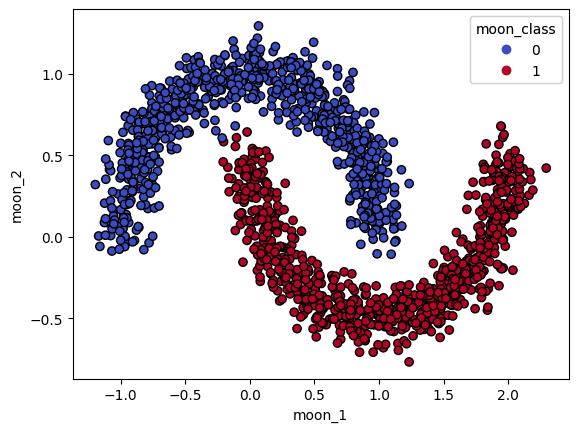

In [34]:
PARAMS = {'booster': 'gbtree', 'n_estimators': 526, 'alpha': 1.724085191941285e-07, 'lambda': 0.0017162392308087727, 'eta': 0.03502541111099623, 'gamma': 0.10166819477407434, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.20000816739969113, 'colsample_bytree': 0.8013891174506724, 'early_stopping_rounds': 47}
model = XGBClassifier(**PARAMS)
model.fit(X_train, y_train, eval_set=[(X_train, y_train)])


# X_test['radius'] = X_test['circle_1'] ** 2 + X_test['circle_2'] ** 2


eps, min_samples = 0.1, 13
dbscan = DBSCAN(eps=0.1, min_samples=13)
X_test['moon_class'] = dbscan.fit_predict(X_test[['moon_1', 'moon_2']])
train_data = X_test[X_test['moon_class'] != -1]
test_data = X_test[X_test['moon_class'] == -1]

X_train1 = train_data[['moon_1', 'moon_2']]
y_train1 = train_data['moon_class']
X_test1 = test_data[['moon_1', 'moon_2']]

knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train1, y_train1)
predicted_labels = knn.predict(X_test1)
X_test.loc[X_test['moon_class'] == -1, 'moon_class'] = predicted_labels

scatterplot(X_test, 'moon_class', 'moon_1', 'moon_2')


X_test.head()
predictions = model.predict(X_test)

In [30]:
X_test[features].head()

NameError: name 'features' is not defined

0       0
1       0
2       1
3       0
4       0
       ..
1582    1
1583    0
1584    0
1585    1
1586    1
Name: moon_class, Length: 1587, dtype: int64
0       1
1       1
2       0
3       1
4       1
       ..
1582    0
1583    1
1584    1
1585    0
1586    0
Name: moon_class, Length: 1587, dtype: int64


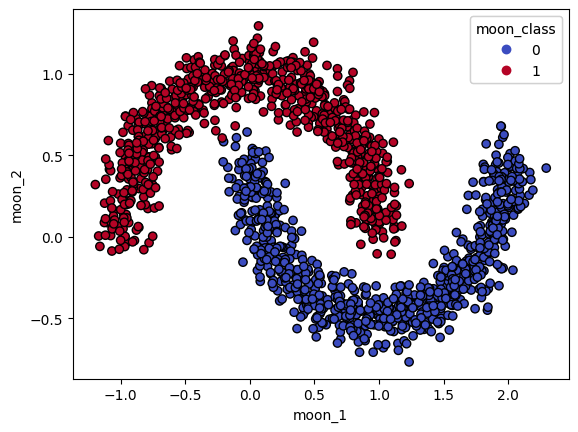

In [35]:
print(X_test['moon_class'])
X_test['moon_class'] = X_test['moon_class'].replace({0: 1, 1: 0})
print(X_test['moon_class'])
scatterplot(X_test, 'moon_class', 'moon_1', 'moon_2')


In [57]:
sub=pd.read_csv(r'C:\Users\arkma\Sqrt-1\putting the pro in programming\ML\GDSC ML\input\sample.csv')
sub["TARGET"]=predictions
sub.to_csv("submission4.csv",index=False) #submit this file 
sub

,ID,TARGET
0,1,0.0
1,3,0.0
2,4,1.0
3,5,0.0
4,6,1.0
...,...,...
1582,1992,1.0
1583,1994,1.0
1584,1995,1.0
1585,1996,1.0
